<a href="https://colab.research.google.com/github/reggiebain/data-projects/blob/main/Multinomial_Movie_Classifier_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Certified Fresh vs. Fresh vs. Rotten
- In this notebook, we use deep learning NLP techniques to predict the ordinal ratings of movies on Rotten Tomatoes.
- Our task will be to predict the "review type" meaning Fresh, or Rotten. Here, we will focus on critic reviews. NOTE: Critic review does not necessarily dictate the tomatometers status overall review.
- In a separate project, we focused on data from audience reviews and found a highly successful classifier. 
- We can train a pre-trained NLP classifier on the sentiment of critic reviews using the "review_type" and "review_content" features

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
%matplotlib inline
import statistics as stats

import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow import keras

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import nltk
nltk.download('stopwords')

#from bert_sklearn import BertClassifier
#from bert_sklearn import BertRegressor
#from bert_sklearn import BertTokenClassifier
#from bert_sklearn import load_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [4]:
# Read in critic reviews of movies
critics = pd.read_csv('/content/drive/MyDrive/Data-Science/rotten_tomatoes_critic_reviews_50k.csv')
movies = pd.read_csv('/content/drive/MyDrive/Data-Science/rotten_tomatoes_movies.csv')
critics.head(1)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...


In [5]:
# Merge data sets to get movie title and tomatometer_status (which is our target).
merged = pd.merge(critics, movies, on='rotten_tomatoes_link')
data = merged[['rotten_tomatoes_link','critic_name','movie_title','review_content','review_type', 'tomatometer_status']]

# Drop rows where there is no target
data_nona = data.dropna(subset=['review_type', 'review_content'])
data_nona.head(1)

,rotten_tomatoes_link,critic_name,movie_title,review_content,review_type,tomatometer_status
0,m/0814255,Andrew L. Urban,Percy Jackson & the Olympians: The Lightning T...,A fantasy adventure that fuses Greek mythology...,Fresh,Rotten


Text(0.5, 1.0, 'Tomatometer Status')

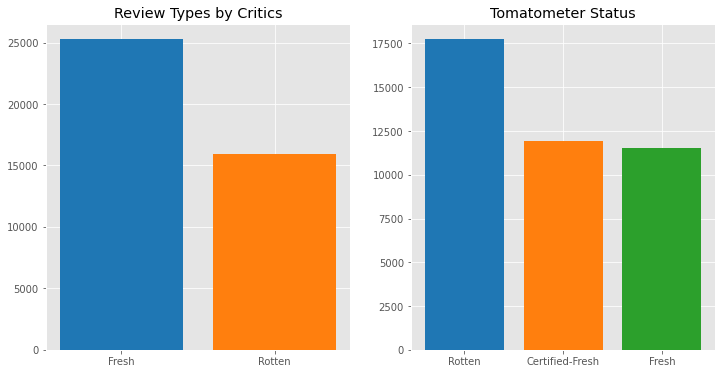

In [6]:
# Declare color map
colormap = mpl.cm.get_cmap('tab10')
# Drop entries with missing data
fig, axs = plt.subplots(1,2, figsize=(12,6))
fig1 = axs[0].bar(x=data_nona.review_type.unique(),height=data_nona.review_type.value_counts(),color=colormap.colors)
axs[0].set_title('Review Types by Critics')
#axs[0].bar_label(fig1, padding = 3)
fig2 = axs[1].bar(x=data_nona.dropna(subset=['tomatometer_status']).tomatometer_status.unique(),height=(data_nona.dropna(subset=['tomatometer_status'])).tomatometer_status.value_counts(),color=colormap.colors)
axs[1].set_title('Tomatometer Status')
#axs[1].bar_label(fig2, padding=3)

<ipython-input-7-736c9576d5ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nona["review_length"] = data_nona["review_content"].apply(lambda x: len(x.split()))
<ipython-input-7-736c9576d5ca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nona['review_length_char'] = data_nona['review_content'].apply(lambda x: len(x))


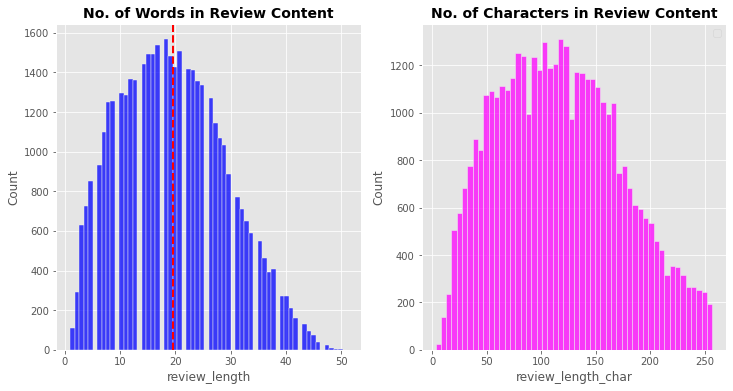

In [7]:
# Plot the distribution of lengths of the reviews (number of characters)
# First get sentence lengths as a new column
data_nona["review_length"] = data_nona["review_content"].apply(lambda x: len(x.split()))
data_nona['review_length_char'] = data_nona['review_content'].apply(lambda x: len(x))
fig, axs = plt.subplots(1,2, figsize=(12,6))
sns.histplot(data_nona['review_length'], ax=axs[0], color='blue')
axs[0].set_title('No. of Words in Review Content', fontsize=14, fontweight='bold')
sns.histplot(data_nona['review_length_char'], ax=axs[1], color='magenta')
axs[1].set_title('No. of Characters in Review Content', fontsize=14, fontweight='bold')

# Add averages 
avg = np.mean(data_nona['review_length'])
axs[0].axvline(avg, color='red', linestyle='dashed', linewidth=2, label='Average')
plt.legend()
plt.show()

#### Isolate training data and Preprocess
- [X] Isolate relevant training/validation/testing data and drop na's
- [X] Define preprocessing function
- [X] Split into train/val/test tests with SKLearn
- [X] Define RNN with LSTMs etc.
- [X] Evaluate Accuracy

At this stage, we have a DF with shape (41195, 8), so 41195 reviews and 8 columns most of which we don't need.

In [8]:
data_nona.shape

(41195, 8)

In [9]:
# Isolate and Preprocess Data
import re
from nltk.corpus import stopwords

data = data_nona[['review_content', 'review_type']]
proc_data = pd.DataFrame()
def preprocess(input):
  stop_words = set(stopwords.words('english'))
  input = re.sub('<br\\s*/?,\(\)>', ' ',input)
  input = re.sub("[^a-zA-Z']", ' ', input)
  input = input.lower()
  input = ' '.join([word for word in input.split() if word not in stop_words])
  return input

data["review_content"] = data["review_content"].apply(lambda text: preprocess(text))

from collections import Counter
cnt = Counter()
for text in data["review_content"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

data['review_content'] = data['review_content'].apply(lambda text: remove_freqwords(text))


# Preprocess review content to clean up review text
X = data['review_content'].values

# Assign 0/1 (or ordinal encoding) to review labels
#proc_data['review_type'] = data.review_type.apply(lambda x: 0 if x=='Rotten' else 1)

# Alternately, use a one hot encoding to get tuples instead of 0 or 1 (which will scale to more categories better)
Y = pd.get_dummies(data['review_type']).values
# Convert the data and target's to lists for tokenizing later
#feature_text_list = proc_data['review_content'].tolist()
#target_list = proc_data['review_type'].tolist()

<ipython-input-9-73946f8ed524>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["review_content"] = data["review_content"].apply(lambda text: preprocess(text))
<ipython-input-9-73946f8ed524>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review_content'] = data['review_content'].apply(lambda text: remove_freqwords(text))


In [10]:
pd.get_dummies(data['review_type'])

,Fresh,Rotten
0,1,0
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
49995,0,1
49996,0,1
49997,0,1
49998,0,1


In [11]:
Y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

At this point we have proc_data, a DF that that has 2 columns
- 'review_content' = DF column (series) of preprocessed string sentences
- 'review_type' = DF column (series) of 0 if 'Rotten' and 1 if not.

In [12]:
# Split the proc_data into train, val, and test sets using sklearn
from sklearn.model_selection import train_test_split 
X_train_full, X_test, y_train_full, y_test = train_test_split(X, Y, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1)

In [13]:
X_train

array(['contrived predictable squandering chemistry co stars sandra bullock ryan reynolds creates lazy escapist entertainment forgotten soon end credits rolled',
       'okay starring vehicle norm macdonald think could better',
       'th question would tv grade travelogue followed halfway decent q warrant theatrical release',
       ..., 'cruel treatment horses may upset kids',
       'interesting meaning italian cultural world capture usual spirit director francesco rosi full review spanish',
       'tell clearly buries compelling aspects beneath action scenes romantic subplots detract'],
      dtype=object)

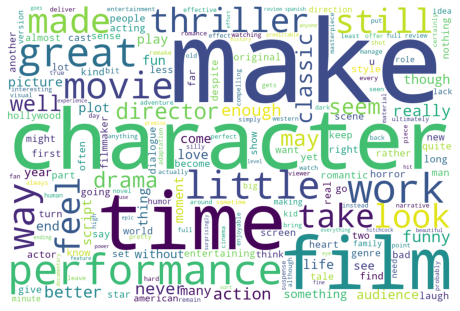

In [14]:
# Create quick word cloud on training data
from wordcloud import WordCloud 
# Create giant list of all word in all sentences
words = ' '.join(X_train)
wordcloud = WordCloud(width=1200, height= 800, background_color='white').generate(words)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [15]:
# Create and train a tokenizer on the training data. Then create a word index.
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers

vocab_size = 5000
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [16]:
# Create sequences for training/val/test data
sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [19]:
# Testing the sequences using the word_index dictionary the tokenizer created. Note OOV token = 1
print(sequences[1])
print(X_train[1])
print(f'okay = {word_index["okay"]}, starring = {word_index["starring"]}, OOV = {word_index["<OOV>"]}')

[2322, 807, 718, 1, 1, 147, 36, 27]
okay starring vehicle norm macdonald think could better
okay = 2322, starring = 807, OOV = 1


In [20]:
# Created list of padded numerical sequences with uniform length 'max_len'. We graphed the no. of words earlier.
max_len = 60
padded = pad_sequences(sequences, maxlen=max_len, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

In [21]:
padded

array([[ 675,  214,    1, ...,    0,    0,    0],
       [2322,  807,  718, ...,    0,    0,    0],
       [ 726, 1038,   26, ...,    0,    0,    0],
       ...,
       [2527, 1253,    1, ...,    0,    0,    0],
       [ 127, 1051, 3986, ...,    0,    0,    0],
       [ 591,  572,    1, ...,    0,    0,    0]], dtype=int32)

In [22]:
print(padded.shape, y_train.shape)

(33367, 60) (33367, 2)


In [36]:
# Defining a simple model using max pool to reduce the input features, no sequence models yet
num_oov_buckets = 1000
embed_size = 20
lstm_out = 15

basic_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embed_size, input_length=max_len),
    keras.layers.SpatialDropout1D(0.2),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Create a callback that will allow for early stopping if the model isn't getting better with more training
from keras.callbacks import ModelCheckpoint
basic_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3)
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_size, input_length=max_len),
    tf.keras.layers.LSTM(lstm_out, dropout=0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])
lstm_optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [37]:
# Compile and print out the details of the model
lstm_model.compile(loss='categorical_crossentropy', optimizer=lstm_optimizer, metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 20)            100000    
                                                                 
 lstm_1 (LSTM)               (None, 15)                2160      
                                                                 
 dense_5 (Dense)             (None, 2)                 32        
                                                                 
Total params: 102,192
Trainable params: 102,192
Non-trainable params: 0
_________________________________________________________________


Some notes on hyperparameters tuning (TODO: Grid Search)
* LSTM Model with Lower Complexity:
  * Train Accuracy , Test Accuracy
  * batch size = 16, epochs = 50, lstm_out = 15, embed size = 20, dropout=0.2, learning rate = 0.0001, optimizer = Adam

* LSTM Model with Higher Complexity:
  * Train Accuracy 88.32%, Test Accuracy 73.69%
  * Batch Size = 64, Epochs = 25, Embed Size = 32, LSTM Out = 100, learning rate = 0.0001, optimizer = Adam   



In [38]:
num_epochs = 50
batch_size = 16
#lstm_history = lstm_model.fit(padded, y_train, epochs = num_epochs, validation_data = (val_padded, y_val), callbacks=[basic_callback])
lstm_history = lstm_model.fit(padded, y_train, epochs = num_epochs, validation_data = (val_padded, y_val), batch_size = batch_size, callbacks=[checkpoint])

Epoch 1/50
2085/2086 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.6125
Epoch 1: val_accuracy improved from -inf to 0.61947, saving model to best_model.hdf5
2086/2086 [==============================] - 54s 24ms/step - loss: 0.6691 - accuracy: 0.6124 - val_loss: 0.6643 - val_accuracy: 0.6195
Epoch 2/50
2086/2086 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.6130
Epoch 2: val_accuracy did not improve from 0.61947
2086/2086 [==============================] - 53s 25ms/step - loss: 0.6675 - accuracy: 0.6130 - val_loss: 0.6643 - val_accuracy: 0.6195
Epoch 3/50
2084/2086 [============================>.] - ETA: 0s - loss: 0.6548 - accuracy: 0.6149
Epoch 3: val_accuracy improved from 0.61947 to 0.74488, saving model to best_model.hdf5
2086/2086 [==============================] - 50s 24ms/step - loss: 0.6547 - accuracy: 0.6151 - val_loss: 0.5632 - val_accuracy: 0.7449
Epoch 4/50
2086/2086 [==============================] - ETA: 0s - loss: 0.511

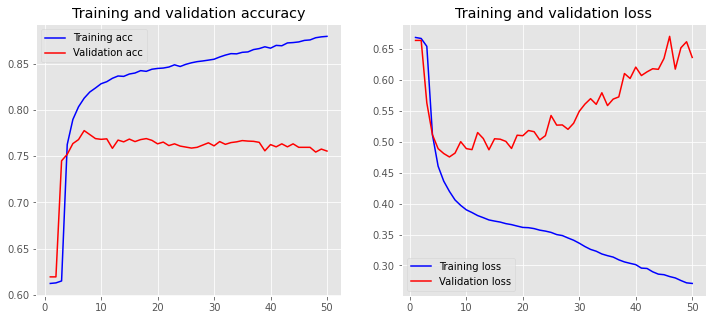

In [39]:
plot_history(lstm_history)

In [40]:
test_loss, test_acc = lstm_model.evaluate(test_padded, y_test)
train_loss, train_acc = lstm_model.evaluate(padded, y_train)
print(f'Train Accuracy = {train_acc:.2%} and Test Accuracy = {test_acc:.2%}')

1043/1043 [==============================] - 6s 6ms/step - loss: 0.2369 - accuracy: 0.8974
Train Accuracy = 89.74% and Test Accuracy = 74.85%


In [41]:
predictions = lstm_model.predict(test_padded)

129/129 [==============================] - 1s 6ms/step


In [42]:
predictions
#y_pred = np.array([1 if p > 0.5 else 0 for p in predictions])

array([[0.7933202 , 0.20667969],
       [0.22890626, 0.7710938 ],
       [0.89027345, 0.1097265 ],
       ...,
       [0.37332913, 0.6266709 ],
       [0.9928067 , 0.00719326],
       [0.99162585, 0.00837408]], dtype=float32)

In [43]:
# Test on individual review to see how it predicts sentiment
test_fresh = 'The movie was awesome.&*& Pure and simple. Great acting on the part of Matt Damon and Brad Pitt. Oceans 11 is the perfect film. I absolutely loved this movie it is my favorite film of all time'
test_rotten = 'Movie was $$ absolutely terrible. I hated every second of it. Bad acting performances. Ewan McGregor was trash.'
print(lstm_model.predict(pad_sequences(tokenizer.texts_to_sequences([preprocess(test_fresh)]), maxlen=max_len, padding='post')))
print(lstm_model.predict(pad_sequences(tokenizer.texts_to_sequences([preprocess(test_rotten)]), maxlen=max_len, padding='post')))

1/1 [==============================] - 0s 18ms/step
[[0.99296665 0.00703341]]
1/1 [==============================] - 0s 17ms/step
[[0.04973686 0.9502632 ]]


              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2526
           1       0.68      0.66      0.67      1594

    accuracy                           0.75      4120
   macro avg       0.73      0.73      0.73      4120
weighted avg       0.75      0.75      0.75      4120



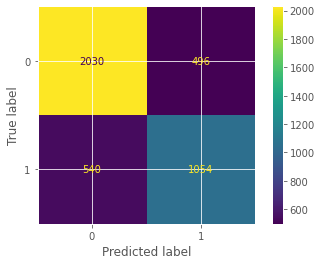

In [44]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
# Plot results via confusion matrix
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1)))
cm = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Scratch Work Area/Alternate model architectures...

In [84]:
# Alternate model using Bi-Directional 1 layer LSTM
model2 = keras.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, input_length=max_len),
    keras.layers.Bidirectional(keras.layers.LSTM(int(embed_size/2), dropout=0.2)),
    keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 60, 128)           1408000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,506,945
Trainable params: 1,506,945
Non-trainable params: 0
_________________________________________________________________


In [85]:
#Implement model checkpoins to get NN performance at its best
from keras.callbacks import ModelCheckpoint
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto',save_weights_only=False)
num_epochs=10
history = model2.fit(padded, y_train_list, epochs = num_epochs, validation_data = (val_padded, y_val_list), callbacks=[checkpoint2])

Epoch 1/10
1042/1043 [============================>.] - ETA: 0s - loss: 0.5099 - accuracy: 0.7424
Epoch 1: val_accuracy improved from -inf to 0.78398, saving model to best_model2.hdf5
1043/1043 [==============================] - 65s 59ms/step - loss: 0.5099 - accuracy: 0.7424 - val_loss: 0.4420 - val_accuracy: 0.7840
Epoch 2/10
1042/1043 [============================>.] - ETA: 0s - loss: 0.3530 - accuracy: 0.8434
Epoch 2: val_accuracy improved from 0.78398 to 0.79504, saving model to best_model2.hdf5
1043/1043 [==============================] - 63s 60ms/step - loss: 0.3530 - accuracy: 0.8433 - val_loss: 0.4334 - val_accuracy: 0.7950
Epoch 3/10
1043/1043 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.8845
Epoch 3: val_accuracy did not improve from 0.79504
1043/1043 [==============================] - 61s 59ms/step - loss: 0.2718 - accuracy: 0.8845 - val_loss: 0.4830 - val_accuracy: 0.7945
Epoch 4/10
1042/1043 [============================>.] - ETA: 0s - loss: 0.2

In [ ]:
best_model = keras.models.load_model("best_model2.hdf5")
test_loss, test_acc = best_model.evaluate(test_padded, y_test_list, verbose=2)
print('Model accuracy: ',test_acc)

129/129 - 8s - loss: 0.4370 - accuracy: 0.7883 - 8s/epoch - 66ms/step
Model accuracy:  0.7883495092391968


In [ ]:
# Create predictions from the best model on the test data
predictions = best_model.predict(test_padded)

129/129 [==============================] - 9s 67ms/step


In [52]:
y_pred = np.around(predictions, decimals=0).argmax(axis=1)
y_test.argmax(axis=1)

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
# Create y_pred, which is a list of 0's and 1's based on the probs we got from the sigmoid later
#y_pred = np.array([1 if p > 0.5 else 0 for p in predictions])

array([1, 0, 1, ..., 0, 0, 1])